
Final Test Metrics:
Mean Accuracy: 0.9243
Mean Precision: 0.8115
Mean Recall: 0.7031
Mean F1 Score: 0.7420


C:\Users\akash\AppData\Local\Temp\ipykernel_19532\1049150978.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Attribute', data=f1_scores, palette="viridis")


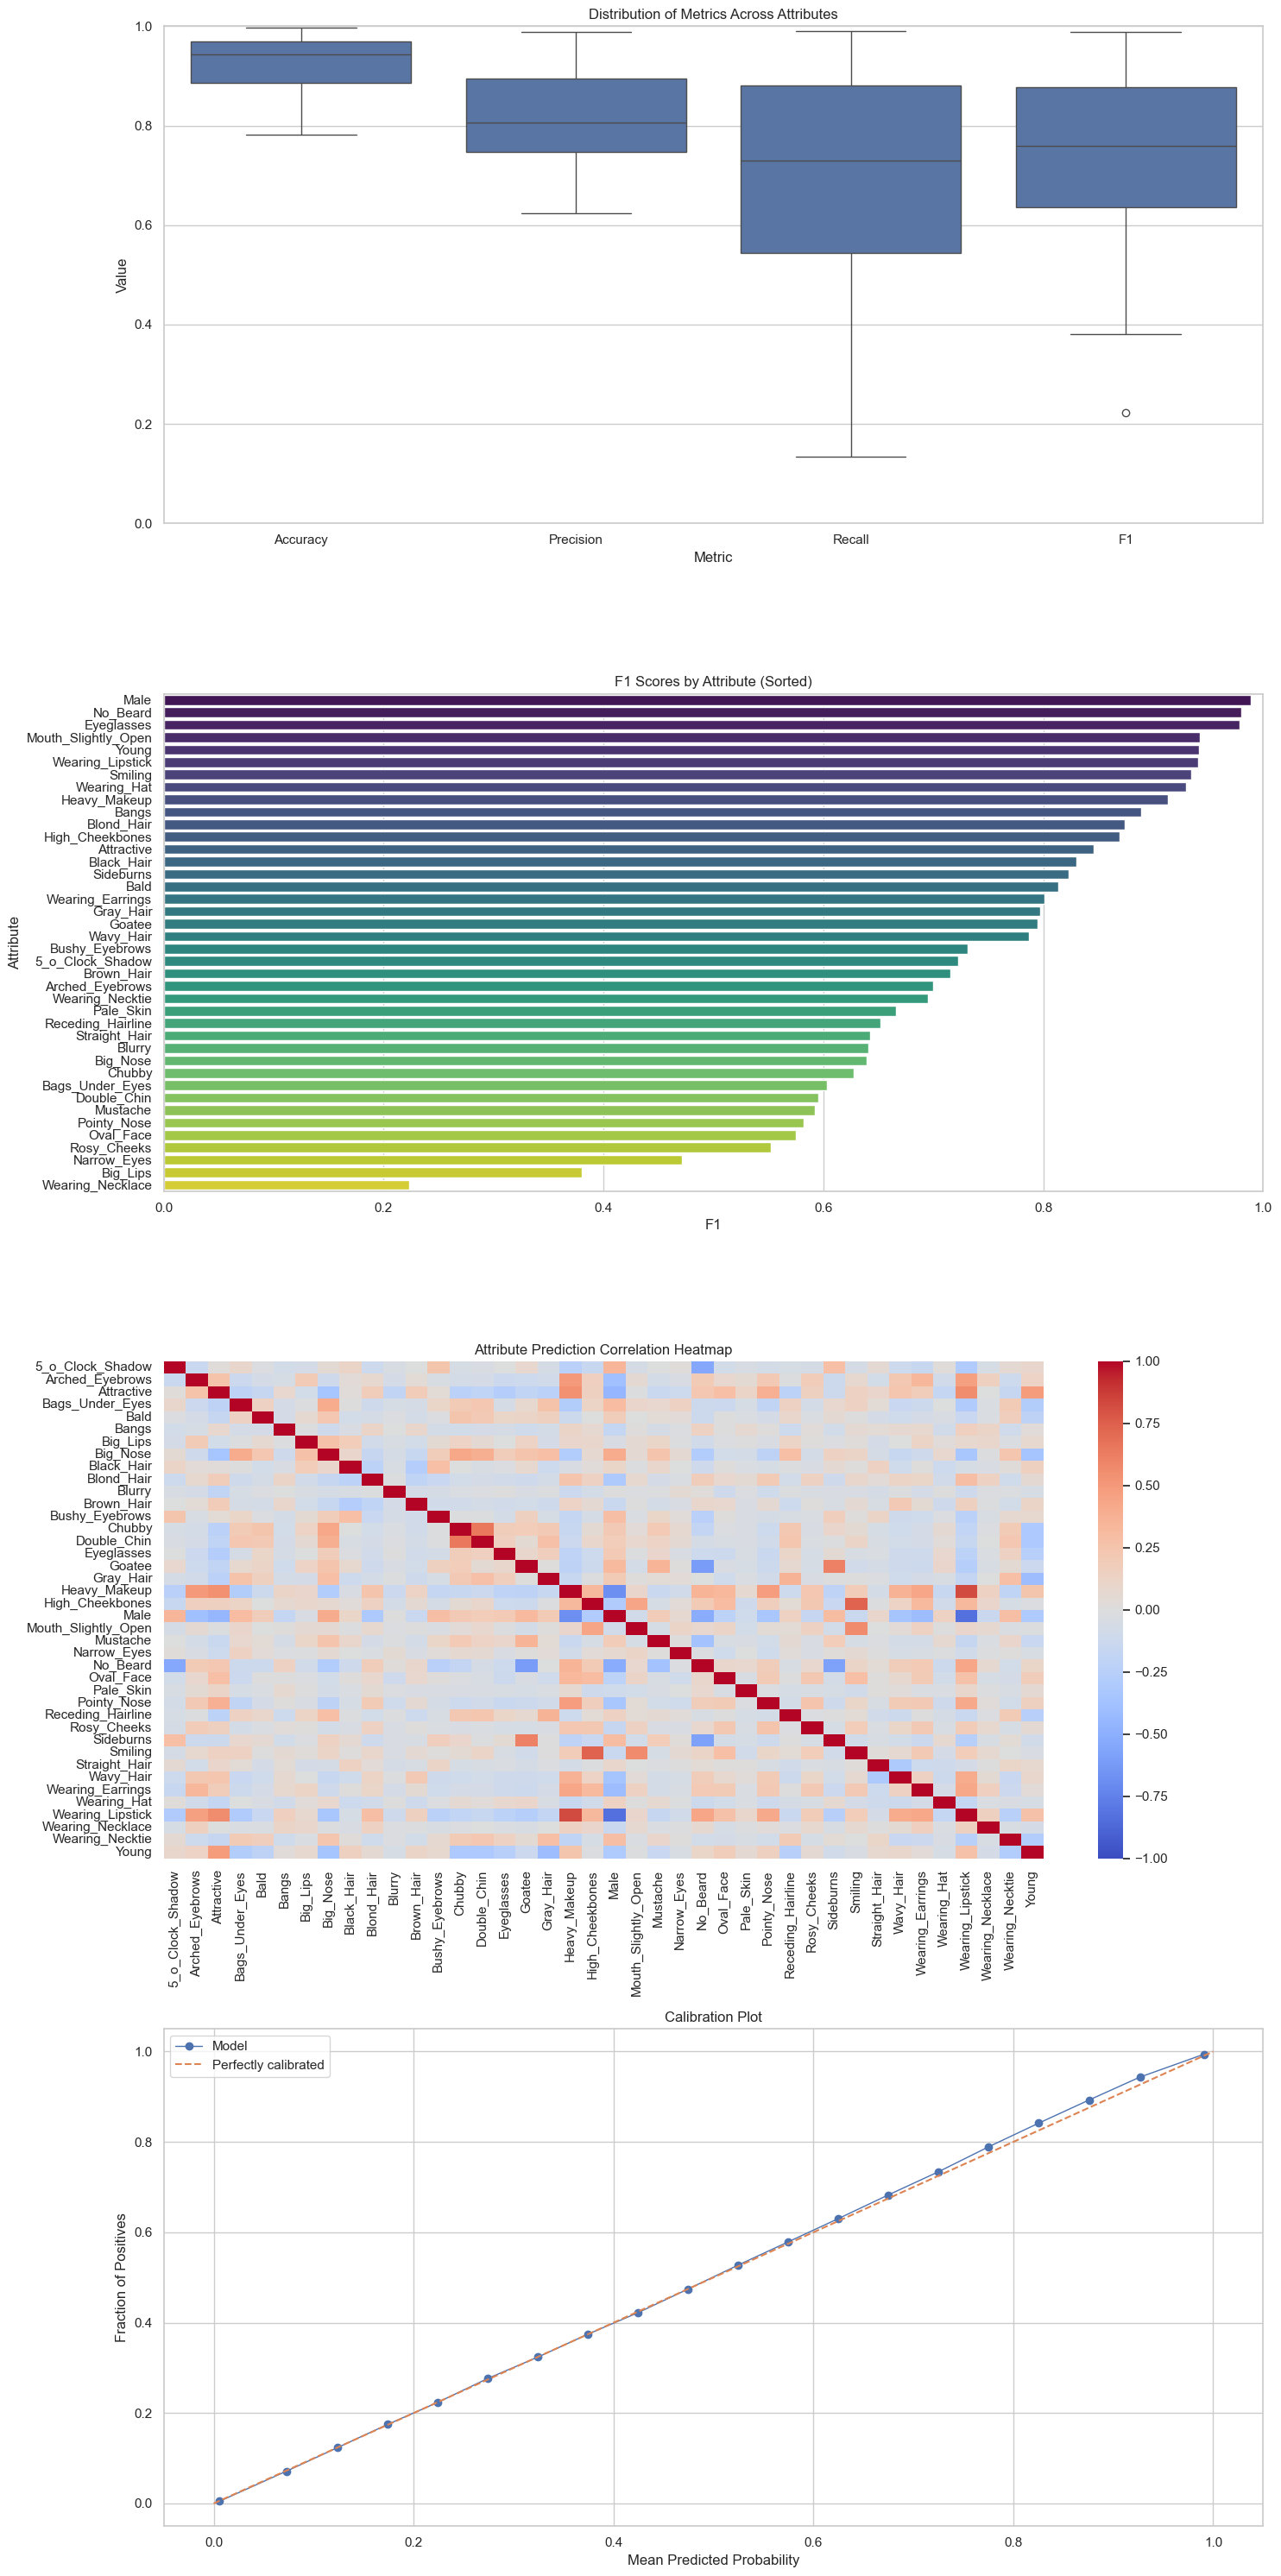

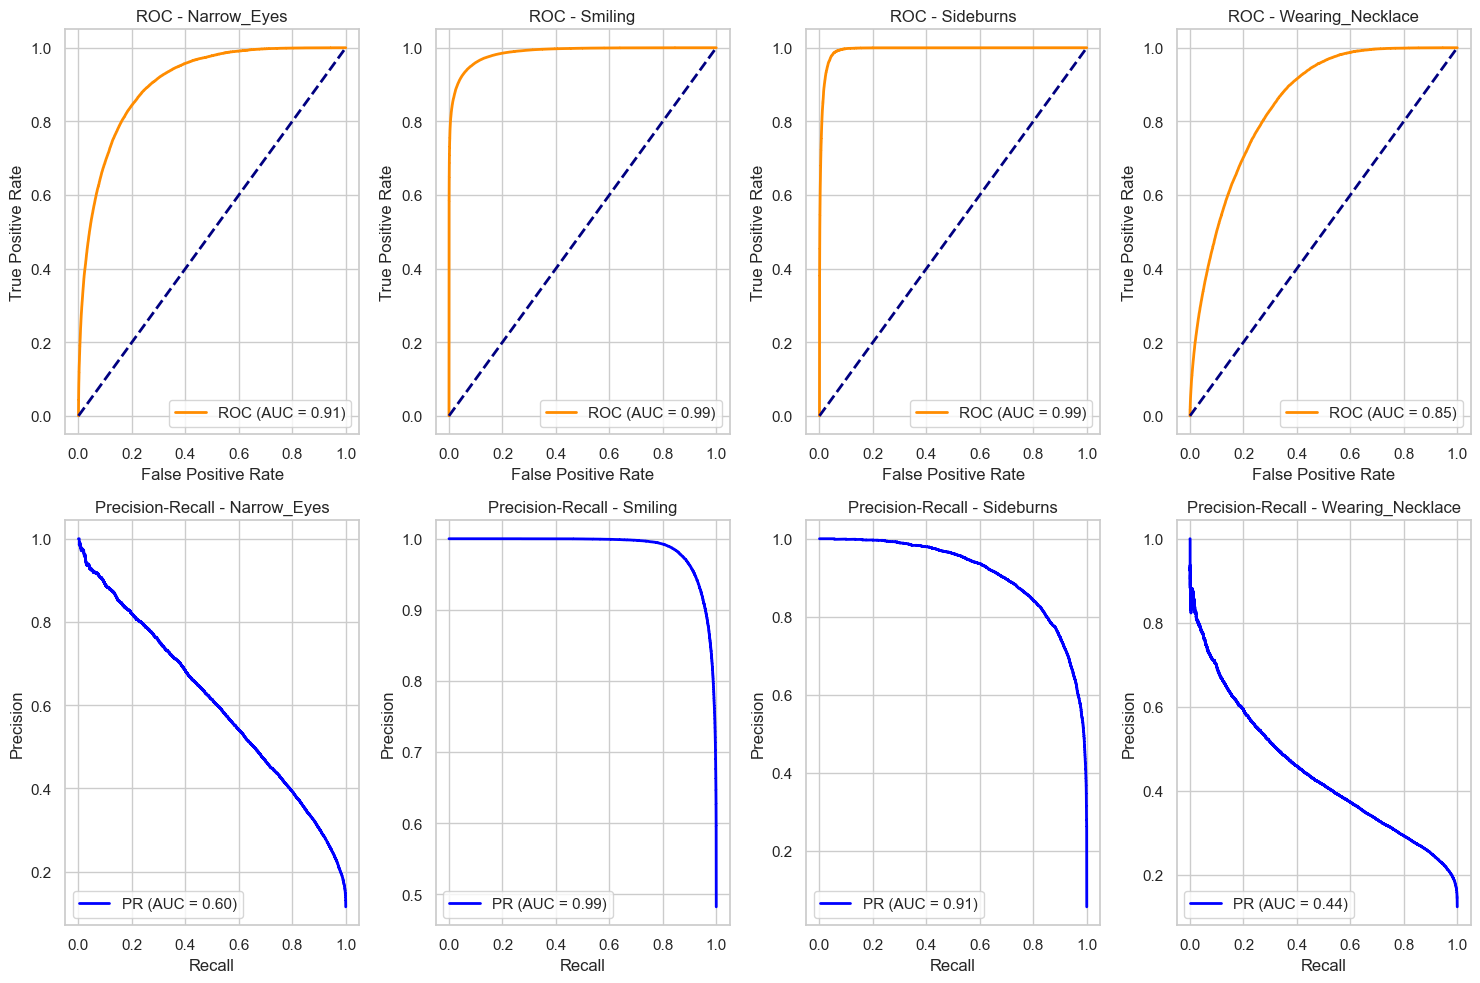

In [3]:
# test_model.py
# test_model.py
!pip install torch torchvision pandas matplotlib seaborn scikit-learn

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
from torchvision import transforms, models  # Added models import here
from typing import Dict
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve  # Added calibration curve import

# Rest of the code remains unchanged...
# Replicate necessary components from training code
class Config:
    root_dir = 'D:/celeba/img_align_celeba/img_align_celeba'
    csv_path = 'D:/celeba/list_attr_celeba.csv'
    num_classes = 40
    batch_size = 64
    image_size = 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    attribute_names = [
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
        'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
        'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
        'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
        'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
        'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
    ]

class CelebADataset:
    def __init__(self, root_dir, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.df.iloc[:, 1:] = self.df.iloc[:, 1:].replace(-1, 0)
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(Config.mean, Config.std)
        ])
        self.image_names = self.df['image_id']
        self.labels = self.df.drop('image_id', axis=1).values.astype('float32')

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        image = Image.open(img_path).convert('RGB')
        return self.transform(image), self.labels[idx]

def load_model(device: torch.device) -> torch.nn.Module:
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(512, Config.num_classes)
    )
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    return model.to(device)

def calculate_metrics(outputs: torch.Tensor, labels: torch.Tensor) -> Dict:
    preds = (torch.sigmoid(outputs) > 0.5).float()
    probs = torch.sigmoid(outputs)
    
    # Per-attribute metrics
    tp = (preds * labels).sum(0).cpu().numpy()
    fp = (preds * (1 - labels)).sum(0).cpu().numpy()
    fn = ((1 - preds) * labels).sum(0).cpu().numpy()
    tn = ((1 - preds) * (1 - labels)).sum(0).cpu().numpy()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'probs': probs.cpu().numpy(),
        'labels': labels.cpu().numpy(),
        'preds': preds.cpu().numpy()
    }

def plot_metrics(metrics: Dict):
    # Set seaborn style
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 30))
    
    # 1. Metric Distribution Plot
    plt.subplot(4, 1, 1)
    metrics_df = pd.DataFrame({
        'Attribute': Config.attribute_names,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1']
    })
    metrics_df = metrics_df.melt(id_vars="Attribute", var_name="Metric", value_name="Value")
    sns.boxplot(x="Metric", y="Value", data=metrics_df)
    plt.title("Distribution of Metrics Across Attributes")
    plt.ylim(0, 1)
    
    # 2. F1 Score Ranking
    plt.subplot(4, 1, 2)
    f1_scores = pd.DataFrame({
        'Attribute': Config.attribute_names,
        'F1': metrics['f1']
    }).sort_values('F1', ascending=False)
    
    sns.barplot(x='F1', y='Attribute', data=f1_scores, palette="viridis")
    plt.title("F1 Scores by Attribute (Sorted)")
    plt.xlim(0, 1)
    plt.tight_layout()
    
    # 3. Correlation Heatmap
    plt.subplot(4, 1, 3)
    correlation_matrix = np.corrcoef(metrics['preds'].T)
    sns.heatmap(correlation_matrix, 
                xticklabels=Config.attribute_names,
                yticklabels=Config.attribute_names,
                cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Attribute Prediction Correlation Heatmap")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # 4. Probability Calibration Plot
    plt.subplot(4, 1, 4)
    prob_true, prob_pred = calibration_curve(
        metrics['labels'].flatten(),
        metrics['probs'].flatten(),
        n_bins=20
    )
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.tight_layout()
    
    plt.show()

def plot_roc_pr_curves(metrics: Dict):
    # Sample 4 random attributes for visualization
    plt.figure(figsize=(15, 10))
    sampled_indices = np.random.choice(len(Config.attribute_names), 4, replace=False)
    
    for i, idx in enumerate(sampled_indices):
        # ROC Curve
        fpr, tpr, _ = roc_curve(metrics['labels'][:, idx], metrics['probs'][:, idx])
        roc_auc = auc(fpr, tpr)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(metrics['labels'][:, idx], metrics['probs'][:, idx])
        pr_auc = auc(recall, precision)
        
        plt.subplot(2, 4, i+1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {Config.attribute_names[idx]}')
        plt.legend(loc="lower right")
        
        plt.subplot(2, 4, i+5)
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall - {Config.attribute_names[idx]}')
        plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

def test_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = load_model(device)
    model.eval()
    
    # Create test dataset and loader
    dataset = CelebADataset(Config.root_dir, Config.csv_path)
    test_loader = DataLoader(
        dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Test loop
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    # Combine results
    outputs = torch.cat(all_outputs)
    labels = torch.cat(all_labels)
    
    # Calculate metrics
    metrics = calculate_metrics(outputs, labels)
    
    # Print results
    print("\nFinal Test Metrics:")
    print(f"Mean Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"Mean Precision: {np.mean(metrics['precision']):.4f}")
    print(f"Mean Recall: {np.mean(metrics['recall']):.4f}")
    print(f"Mean F1 Score: {np.mean(metrics['f1']):.4f}")
    
    # Generate visualizations
    plot_metrics(metrics)
    plot_roc_pr_curves(metrics)
    
    # Save metrics for further analysis
    metrics_df = pd.DataFrame({
        'Attribute': Config.attribute_names,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1']
    })
    metrics_df.to_csv('attribute_metrics.csv', index=False)

if __name__ == "__main__":
    test_model()